In [1]:
# Python code to read the extracted party information from the new JSON file
import json

# Reading the JSON file containing the extracted party information
extracted_file_path = 'election_data/extracted_parties.json'

with open(extracted_file_path, 'r', encoding='utf-8') as file:
    extracted_parties_data = json.load(file)

# Example: Accessing the first party's information
first_party = extracted_parties_data[0] if extracted_parties_data else None

first_party


{'partei_id': 1,
 'partei_bezeichnung': [{'langKey': 'de', 'text': 'FDP.Die Liberalen'},
  {'langKey': 'fr', 'text': 'PLR.Les Libéraux'},
  {'langKey': 'it', 'text': 'PLR.I Liberali Radicali'},
  {'langKey': 'en', 'text': 'FDP.The Liberals'}],
 'partei_bezeichnung_kurz': [{'langKey': 'de', 'text': 'FDP'},
  {'langKey': 'fr', 'text': 'PLR'},
  {'langKey': 'it', 'text': 'PLR'},
  {'langKey': 'en', 'text': 'FDP'}],
 'parteigruppen_id': 201,
 'parteigruppen_bezeichnung': [{'langKey': 'de',
   'text': 'FDP.Die Liberalen (inkl. LPS)'},
  {'langKey': 'fr', 'text': 'PLR.Les Libéraux (y.c. PLS)'},
  {'langKey': 'it', 'text': 'PLR.I Liberali Radicali (incl. PLS)'},
  {'langKey': 'en', 'text': 'FDP.The Liberals (inc. LPS)'}],
 'parteigruppen_bezeichnung_kurz': [{'langKey': 'de', 'text': 'FDP (LPS)'},
  {'langKey': 'fr', 'text': 'PLR (PLS)'},
  {'langKey': 'it', 'text': 'PLR (PLS)'},
  {'langKey': 'en', 'text': 'FDP (LPS)'}],
 'parteipolitische_lager_id': 303,
 'parteipolitische_lager_bezeichnung'

In [2]:
def get_party_by_id(party_data, party_id):
    """
    Returns the party information for a given party ID.

    :param party_data: List of dictionaries containing party information.
    :param party_id: ID of the party to be retrieved.
    :return: Dictionary containing the party information, or None if not found.
    """
    for party in party_data:
        if party.get('partei_id') == party_id:
            return party
    return None

# Beispiel für die Verwendung
party_id_to_find = 3  # Ersetzen Sie dies durch die gewünschte Partei-ID
found_party = get_party_by_id(extracted_parties_data, party_id_to_find)

print(found_party)


{'partei_id': 3, 'partei_bezeichnung': [{'langKey': 'de', 'text': 'Sozialdemokratische Partei der Schweiz'}, {'langKey': 'fr', 'text': 'Parti socialiste suisse'}, {'langKey': 'it', 'text': 'Partito socialista svizzero'}, {'langKey': 'en', 'text': 'Social Democratic Party'}], 'partei_bezeichnung_kurz': [{'langKey': 'de', 'text': 'SP'}, {'langKey': 'fr', 'text': 'PS'}, {'langKey': 'it', 'text': 'PS'}, {'langKey': 'en', 'text': 'SP'}], 'parteigruppen_id': 203, 'parteigruppen_bezeichnung': [{'langKey': 'de', 'text': 'Sozialdemokratische Partei der Schweiz'}, {'langKey': 'fr', 'text': 'Parti socialiste suisse'}, {'langKey': 'it', 'text': 'Partito socialista svizzero'}, {'langKey': 'en', 'text': 'Social Democratic Party'}], 'parteigruppen_bezeichnung_kurz': [{'langKey': 'de', 'text': 'SP'}, {'langKey': 'fr', 'text': 'PS'}, {'langKey': 'it', 'text': 'PS'}, {'langKey': 'en', 'text': 'SP'}], 'parteipolitische_lager_id': 301, 'parteipolitische_lager_bezeichnung': [{'langKey': 'de', 'text': 'Link

In [3]:
def create_party_id_description_map(party_data):
    """
    Creates a map of party IDs to their short descriptions.

    :param party_data: List of dictionaries containing party information.
    :return: Dictionary mapping party IDs to their short descriptions.
    """
    id_description_map = {}
    for party in party_data:
        # Assuming the short description is in the field 'partei_bezeichnung_kurz' under 'de' langKey
        short_description = next((desc['text'] for desc in party['partei_bezeichnung_kurz'] if desc['langKey'] == 'de'), 'Keine Beschreibung')
        id_description_map[party['partei_id']] = short_description

    return id_description_map

# Create the map
party_id_description_map = create_party_id_description_map(extracted_parties_data)

party_id_description_map

{1: 'FDP',
 2: 'CVP',
 3: 'SP',
 4: 'SVP',
 5: 'LPS',
 6: 'LdU',
 7: 'EVP',
 8: 'CSP',
 9: 'PdA/Sol.',
 12: 'FGA',
 13: 'GRÜNE',
 14: 'SD',
 16: 'EDU',
 18: 'Lega',
 31: 'GLP',
 32: 'BDP',
 33: 'MCR',
 34: 'Mitte',
 35: 'Übrige'}

In [4]:
import json

def extract_election_data(file_path):
    """
    Extracts election data from a given JSON file.

    :param file_path: Path to the JSON file containing election data.
    :return: A list of dictionaries containing the extracted election data.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Assuming the election data is stored under the key 'level_gemeinden'
    election_data_municipality_level = data.get('level_gemeinden', [])
    return election_data_municipality_level

# Beispiel für die Verwendung
file_path = 'election_data/dataset_elections_bfs_municipalities_only.json'  # Ersetzen Sie dies durch den tatsächlichen Dateipfad
election_data_municipality_level = extract_election_data(file_path)

# Hier können Sie dann mit den extrahierten Daten arbeiten
print(election_data_municipality_level[:20])  # Zeigt die ersten fünf Datensätze zur Überprüfung


[{'gemeinde_nummer': 1, 'gemeinde_bezeichnung': 'Aeugst am Albis', 'kanton_nummer': 1, 'partei_id': 1, 'stimmen_partei': 3692, 'letzte_wahl_stimmen_partei': 4457, 'differenz_stimmen_partei': -765, 'partei_staerke': 12.733669035, 'letzte_wahl_partei_staerke': 16.421044875, 'differenz_partei_staerke': -3.68737584, 'partei_rang': 4, 'flag_staerkste_partei': 0}, {'gemeinde_nummer': 1, 'gemeinde_bezeichnung': 'Aeugst am Albis', 'kanton_nummer': 1, 'partei_id': 3, 'stimmen_partei': 3938, 'letzte_wahl_stimmen_partei': 3139, 'differenz_stimmen_partei': 799, 'partei_staerke': 13.582120439, 'letzte_wahl_partei_staerke': 11.565102056, 'differenz_partei_staerke': 2.0170183829, 'partei_rang': 3, 'flag_staerkste_partei': 0}, {'gemeinde_nummer': 1, 'gemeinde_bezeichnung': 'Aeugst am Albis', 'kanton_nummer': 1, 'partei_id': 4, 'stimmen_partei': 9928, 'letzte_wahl_stimmen_partei': 8246, 'differenz_stimmen_partei': 1682, 'partei_staerke': 34.241567221, 'letzte_wahl_partei_staerke': 30.380959399, 'differ

In [5]:
import pandas as pd

# Path to the CSV file
file_path = 'election_data/inhabitants_2022_index_value.csv'

# Read the CSV file into a DataFrame
data_df = pd.read_csv(file_path, delimiter=':', header=None)

# Convert the DataFrame into a dictionary (map)
inhabitants_map = data_df.set_index(0)[1].to_dict()

# Example: Accessing the first few items from the map
for key, value in list(inhabitants_map.items())[:30]:
    print(f"{key}: {value}")


8100: 8646162
ZH: 1552408
000101: 56407
0001: 1979
0002: 12340
0003: 5592
0004: 3851
0005: 3836
0006: 1313
0007: 2410
0008: 642
0009: 5600
0010: 5761
0011: 2847
0012: 1147
0013: 3845
0014: 5244
000102: 31849
0021: 699
0022: 842
0023: 586
0024: 1034
0025: 1933
0026: 707
0027: 3718
0028: 1453
0029: 1499
0030: 2200
0031: 2234
0032: 493


In [6]:
def get_inhabitants_amount_voted(data_map, municipality_id, percentage):
    """
    Aktualisiert den Wert für eine gegebene Gemeinde-ID in der Map basierend auf der angegebenen Prozentzahl.

    :param data_map: Eine Map von Gemeinde-IDs zu ihren Werten.
    :param gemeinde_id: Die ID der Gemeinde, deren Wert aktualisiert werden soll.
    :param percentage: Die Prozentzahl, mit der der Wert aktualisiert werden soll.
    :return: Aktualisierter Wert für die gegebene Gemeinde-ID, oder None, falls die ID nicht in der Map existiert.
    """
    if municipality_id in data_map:
        inhabitants_in_municipality = data_map[municipality_id]
        percentage_voted = inhabitants_in_municipality * percentage
        return percentage_voted
    else:
        return None


In [7]:
percentage_voted = get_inhabitants_amount_voted(inhabitants_map, '0011', 0.25)

if percentage_voted is not None:
    print(f"Der aktualisierte Wert für die Gemeinde-ID '0011' ist: {percentage_voted}")
else:
    print("Gemeinde-ID nicht gefunden.")

Der aktualisierte Wert für die Gemeinde-ID '0011' ist: 711.75


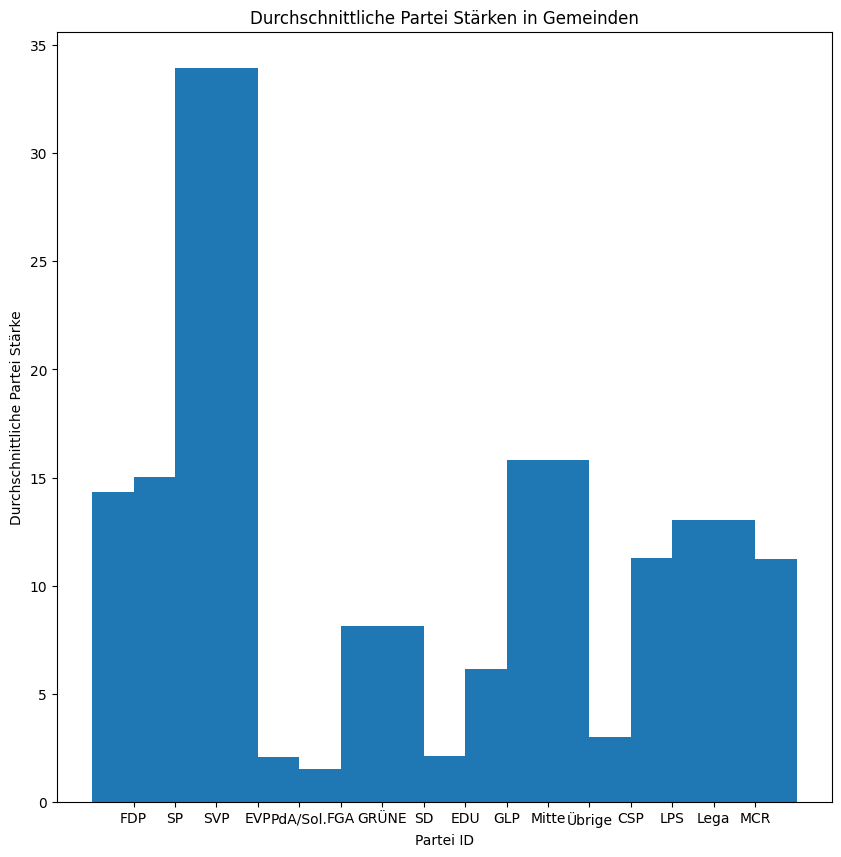

[1, 3, 4, 7, 9, 12, 13, 14, 16, 31, 34, 35, 8, 5, 18, 33]
[14.317017067086072, 15.006441162234736, 33.92903464000471, 2.070435721132651, 1.5101238618308055, 0.3336818371428572, 8.133210680170535, 0.2750460582123081, 2.1284168688777108, 6.13588879502408, 15.816076831774811, 2.999515219305314, 2.069241061842519, 11.27193432375, 13.047533156773593, 11.231842709217391]
['FDP', 'SP', 'SVP', 'EVP', 'PdA/Sol.', 'FGA', 'GRÜNE', 'SD', 'EDU', 'GLP', 'Mitte', 'Übrige', 'CSP', 'LPS', 'Lega', 'MCR']


In [30]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Funktion zur Berechnung der durchschnittlichen Parteistärke
def calculate_average_party_strength(election_data):
    party_strengths = defaultdict(list)

    for entry in election_data:
        party_id = entry.get('partei_id')
        party_strength = entry.get('partei_staerke')

        if party_id is not None and party_strength is not None:
            if isinstance(party_strength, str) and party_strength.endswith('%'):
                party_strength = float(party_strength.strip('%')) / 100
            elif isinstance(party_strength, str):
                party_strength = float(party_strength)

            party_strengths[party_id].append(party_strength)

    average_strengths = {party: sum(strengths) / len(strengths) for party, strengths in party_strengths.items()}
    return average_strengths


# Durchschnitt berechnen
average_strengths = calculate_average_party_strength(election_data_municipality_level)

# Daten für das Balkendiagramm vorbereiten
parties = list(average_strengths.keys())
averages = list(average_strengths.values())
party_names = list()
for party in parties:
    party_names.append(party_id_description_map[party])
    

# Balkendiagramm erstellen
plt.figure(figsize=(10, 10))
plt.bar(party_names, averages, width=2,) 
plt.xlabel('Partei ID')
plt.ylabel('Durchschnittliche Partei Stärke')
plt.title('Durchschnittliche Partei Stärken in Gemeinden')
plt.show()

print(parties)
print(averages)
print(party_names)

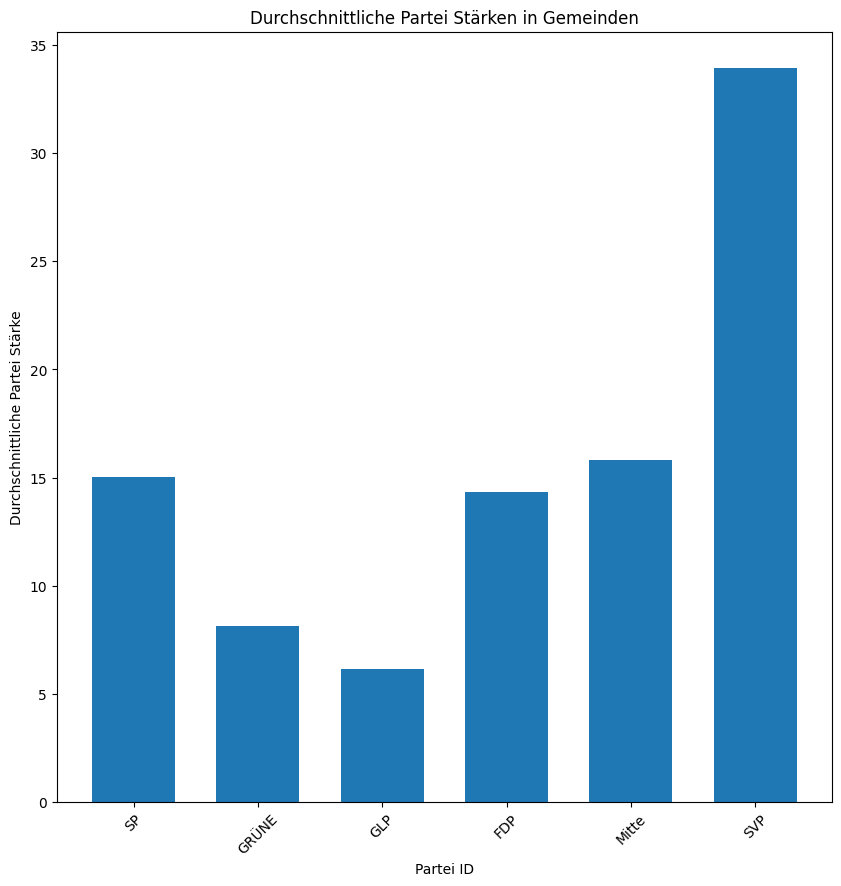

[1, 3, 4, 7, 9, 12, 13, 14, 16, 31, 34, 35, 8, 5, 18, 33]
[15.006441162234736, 8.133210680170535, 6.13588879502408, 14.317017067086072, 15.816076831774811, 33.92903464000471]
['SP', 'GRÜNE', 'GLP', 'FDP', 'Mitte', 'SVP']


In [38]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Funktion zur Berechnung der durchschnittlichen Parteistärke
def calculate_average_party_strength(election_data):
    party_strengths = defaultdict(list)

    for entry in election_data:
        party_id = entry.get('partei_id')
        party_strength = entry.get('partei_staerke')

        if party_id is not None and party_strength is not None:
            if isinstance(party_strength, str) and party_strength.endswith('%'):
                party_strength = float(party_strength.strip('%')) / 100
            elif isinstance(party_strength, str):
                party_strength = float(party_strength)

            party_strengths[party_id].append(party_strength)

    average_strengths = {party: sum(strengths) / len(strengths) for party, strengths in party_strengths.items() if strengths}
    return average_strengths

# Durchschnitt berechnen
average_strengths = calculate_average_party_strength(election_data_municipality_level)

# Daten für das Balkendiagramm vorbereiten
parties = list(average_strengths.keys())
averages = list(average_strengths.values())
party_names = [party_id_description_map[party] for party in parties]

important_parties_keys = list()
important_parties_values = list()
list_of_important_parties = ["SP", "GRÜNE", "GLP", "FDP", "Mitte", "SVP"]

for important_party in list_of_important_parties:
    index_of_string = party_names.index(important_party)
    important_parties_keys.append(important_party)
    important_parties_values.append(averages[index_of_string])


# Balkendiagramm erstellen
plt.figure(figsize=(10, 10))
x_positions = np.arange(len(important_parties_keys)) * 3 
plt.bar(x_positions, important_parties_values, width=2) 
plt.xlabel('Partei ID')
plt.ylabel('Durchschnittliche Partei Stärke')
plt.title('Durchschnittliche Partei Stärken in Gemeinden')
plt.xticks(x_positions, important_parties_keys, rotation=45)  
plt.show()

print(parties)
print(important_parties_values)
print(important_parties_keys)


In [ ]:
from collections import defaultdict


def calculate_total_population_by_party():
    total_population_by_party = defaultdict(float)

    for entry in election_data_municipality_level:
        party_id = entry.get('partei_id')
        gemeinde_nummer = entry.get('gemeinde_nummer')
        party_strength = float(entry.get('partei_staerke').strip('%')) / 100 if isinstance(entry.get('partei_staerke'), str) else entry.get('partei_staerke')
        
        gemeinde_nummer = gemeinde_nummer.zfill(4)
        
        if gemeinde_nummer in inhabitants_map:
            total_population_by_party[party_id] += population_map[gemeinde_nummer] * party_strength

    return total_population_by_party

def categorize_parties_by_population(total_population_by_party):
    buckets = {
        '>75’000': [],
        '30’000-75’000': [],
        '10’000-30’000': [],
        '0-10’000': []
    }

    for party, population in total_population_by_party.items():
        if population > 75000:
            buckets['>75’000'].append(party)
        elif population > 30000:
            buckets['30’000-75’000'].append(party)
        elif population > 10000:
            buckets['10’000-30’000'].append(party)
        else:
            buckets['0-10’000'].append(party)

    return buckets

# Gesamteinwohnerzahl für jede Partei berechnen
total_population_by_party = calculate_total_population_by_party(election_data_municipality_level, population_map)

# Parteien in Buckets einteilen
party_buckets = categorize_parties_by_population(total_population_by_party)

# Ergebnisse ausgeben
for bucket, parties in party_buckets.items():
    print(f"{bucket}: {parties}")
